In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import NelsonAalenFitter, CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimSun']

In [2]:
df = pd.read_csv('./credit_record.csv')
print(df.shape)
group = df.groupby('ID')

(1048575, 3)


In [3]:
application = pd.read_csv('./application_record.csv')

In [4]:
pivot_table = df.pivot(index='ID', columns='MONTHS_BALANCE', values='STATUS')
pivot_table

MONTHS_BALANCE,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51,...,-9,-8,-7,-6,-5,-4,-3,-2,-1,0
ID,,,,,,,,,,,,,,,,,,,,,
5001711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,X
5001712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,C,C,C,C,C,C,C,C,C
5001713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,X,X,X,X,X,X,X,X,X,X
5001714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,X,X,X,X,X,X,X,X,X,X
5001715,NaN,X,X,X,X,X,X,X,X,X,...,X,X,X,X,X,X,X,X,X,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5150482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5150483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,X,X,X,X,X,X,X,X,X,X
5150484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,C


In [5]:
pivot_table['open'] = group['MONTHS_BALANCE'].min()
pivot_table['close'] = group['MONTHS_BALANCE'].max()
pivot_table['ID'] = pivot_table.index
pivot_table = pivot_table[['ID', 'open', 'close']]
pivot_table['window'] = pivot_table['close'] - pivot_table['open']
pivot_table.reset_index(drop=True, inplace=True)
pivot_table

MONTHS_BALANCE,ID,open,close,window
0,5001711,-3,0,3
1,5001712,-18,0,18
2,5001713,-21,0,21
3,5001714,-14,0,14
4,5001715,-59,0,59
...,...,...,...,...
45980,5150482,-28,-11,17
45981,5150483,-17,0,17
45982,5150484,-12,0,12
45983,5150485,-1,0,1


In [6]:
credit_data = pd.merge(df,pivot_table,on='ID',how='left')
credit_copy = credit_data.copy()
credit_data

,ID,MONTHS_BALANCE,STATUS,open,close,window
0,5001711,0,X,-3,0,3
1,5001711,-1,0,-3,0,3
2,5001711,-2,0,-3,0,3
3,5001711,-3,0,-3,0,3
4,5001712,0,C,-18,0,18
...,...,...,...,...,...,...
1048570,5150487,-25,C,-29,0,29
1048571,5150487,-26,C,-29,0,29
1048572,5150487,-27,C,-29,0,29
1048573,5150487,-28,C,-29,0,29


# EDA
表格整理完成，接著進行vintage analysis

In [7]:
# 不到20個月的移除
credit_data = credit_data[credit_data['window'] > 20]



credit_data['status'] = np.where((credit_data['STATUS'] == '2') | (credit_data['STATUS'] == '3') | (credit_data['STATUS'] == '4') | (credit_data['STATUS'] =='5'), 1, 0)
credit_data['status'] = credit_data['status'].astype(np.int8)
credit_data['month_on_book'] = credit_data['MONTHS_BALANCE']-credit_data['open']
credit_data.sort_values(by=['ID','month_on_book'], inplace=True)


divisor = pivot_table.groupby('open').agg({'ID': 'count'}).reset_index()
divisor.columns = ['open_month', 'sta_sum']

vintage_data = credit_data.groupby(['open','month_on_book']).agg({'ID': 'count'}).reset_index()
vintage_data.columns = ['open_month', 'month_on_book', 'sta_sum']
vintage_data['due_count'] = np.nan
vintage_data = vintage_data[['open_month','month_on_book','due_count']]
vintage_data = pd.merge(vintage_data, divisor, on='open_month', how='left')
vintage_data


,open_month,month_on_book,due_count,sta_sum
0,-60,0,NaN,415
1,-60,1,NaN,415
2,-60,2,NaN,415
3,-60,3,NaN,415
4,-60,4,NaN,415
...,...,...,...,...
1655,-21,17,NaN,858
1656,-21,18,NaN,858
1657,-21,19,NaN,858
1658,-21,20,NaN,858


In [8]:
credit_data[(credit_data['status'] == 1)]

,ID,MONTHS_BALANCE,STATUS,open,close,window,status,month_on_book
8915,5002126,-50,2,-55,0,55,1,5
8914,5002126,-49,2,-55,0,55,1,6
8913,5002126,-48,3,-55,0,55,1,7
8912,5002126,-47,3,-55,0,55,1,8
8911,5002126,-46,2,-55,0,55,1,9
...,...,...,...,...,...,...,...,...
1041041,5149838,-17,5,-32,0,32,1,15
1041040,5149838,-16,5,-32,0,32,1,16
1041039,5149838,-15,5,-32,0,32,1,17
1041038,5149838,-14,5,-32,0,32,1,18


In [9]:
for j in range(-60,1):
    lists = []
    for i in range(0,61):
        due = list(credit_data[(credit_data['status']== 1) & (credit_data['month_on_book'] == i) & (credit_data['open'] == j)]['ID'])
        lists.extend(due)
        vintage_data.loc[(vintage_data['month_on_book'] == i) & (vintage_data['open_month']==j),'due_count'] = len(set(lists))
vintage_data['sta_ratio'] = vintage_data['due_count']/vintage_data['sta_sum']
vintage_data

,open_month,month_on_book,due_count,sta_sum,sta_ratio
0,-60,0,0.0,415,0.000000
1,-60,1,0.0,415,0.000000
2,-60,2,0.0,415,0.000000
3,-60,3,0.0,415,0.000000
4,-60,4,0.0,415,0.000000
...,...,...,...,...,...
1655,-21,17,15.0,858,0.017483
1656,-21,18,15.0,858,0.017483
1657,-21,19,15.0,858,0.017483
1658,-21,20,15.0,858,0.017483


In [10]:
vintage_wide = vintage_data.pivot(index='open_month',columns='month_on_book',values='sta_ratio')
vintage_wide

month_on_book,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
open_month,,,,,,,,,,,,,,,,,,,,,
-60,0.00000,0.000000,0.000000,0.000000,0.000000,0.002410,0.002410,0.007229,0.007229,0.009639,...,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.031325,0.031325,0.031325
-59,0.00000,0.000000,0.000000,0.004926,0.004926,0.004926,0.007389,0.007389,0.007389,0.012315,...,0.029557,0.029557,0.029557,0.032020,0.032020,0.032020,0.032020,0.032020,0.032020,NaN
-58,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004545,0.006818,0.006818,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN
-57,0.00000,0.000000,0.000000,0.000000,0.002500,0.002500,0.002500,0.007500,0.007500,0.007500,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN,NaN
-56,0.00000,0.000000,0.004255,0.004255,0.008511,0.010638,0.010638,0.017021,0.017021,0.021277,...,0.036170,0.036170,0.036170,0.036170,0.038298,0.038298,NaN,NaN,NaN,NaN
-55,0.00000,0.000000,0.002058,0.006173,0.012346,0.016461,0.022634,0.022634,0.022634,0.024691,...,0.045267,0.045267,0.045267,0.045267,0.045267,NaN,NaN,NaN,NaN,NaN
-54,0.00000,0.000000,0.000000,0.002137,0.004274,0.004274,0.006410,0.012821,0.012821,0.017094,...,0.032051,0.032051,0.032051,0.032051,NaN,NaN,NaN,NaN,NaN,NaN
-53,0.00000,0.002028,0.002028,0.002028,0.004057,0.004057,0.008114,0.010142,0.010142,0.012170,...,0.028398,0.028398,0.028398,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-52,0.00000,0.000000,0.007233,0.009042,0.009042,0.009042,0.012658,0.012658,0.014467,0.016275,...,0.023508,0.023508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
print(vintage_wide)

month_on_book       0         1         2         3         4         5   \
open_month                                                                 
-60            0.00000  0.000000  0.000000  0.000000  0.000000  0.002410   
-59            0.00000  0.000000  0.000000  0.004926  0.004926  0.004926   
-58            0.00000  0.000000  0.000000  0.000000  0.000000  0.000000   
-57            0.00000  0.000000  0.000000  0.000000  0.002500  0.002500   
-56            0.00000  0.000000  0.004255  0.004255  0.008511  0.010638   
-55            0.00000  0.000000  0.002058  0.006173  0.012346  0.016461   
-54            0.00000  0.000000  0.000000  0.002137  0.004274  0.004274   
-53            0.00000  0.002028  0.002028  0.002028  0.004057  0.004057   
-52            0.00000  0.000000  0.007233  0.009042  0.009042  0.009042   
-51            0.00000  0.001718  0.001718  0.003436  0.003436  0.008591   
-50            0.00000  0.000000  0.001842  0.003683  0.007366  0.007366   
-49         

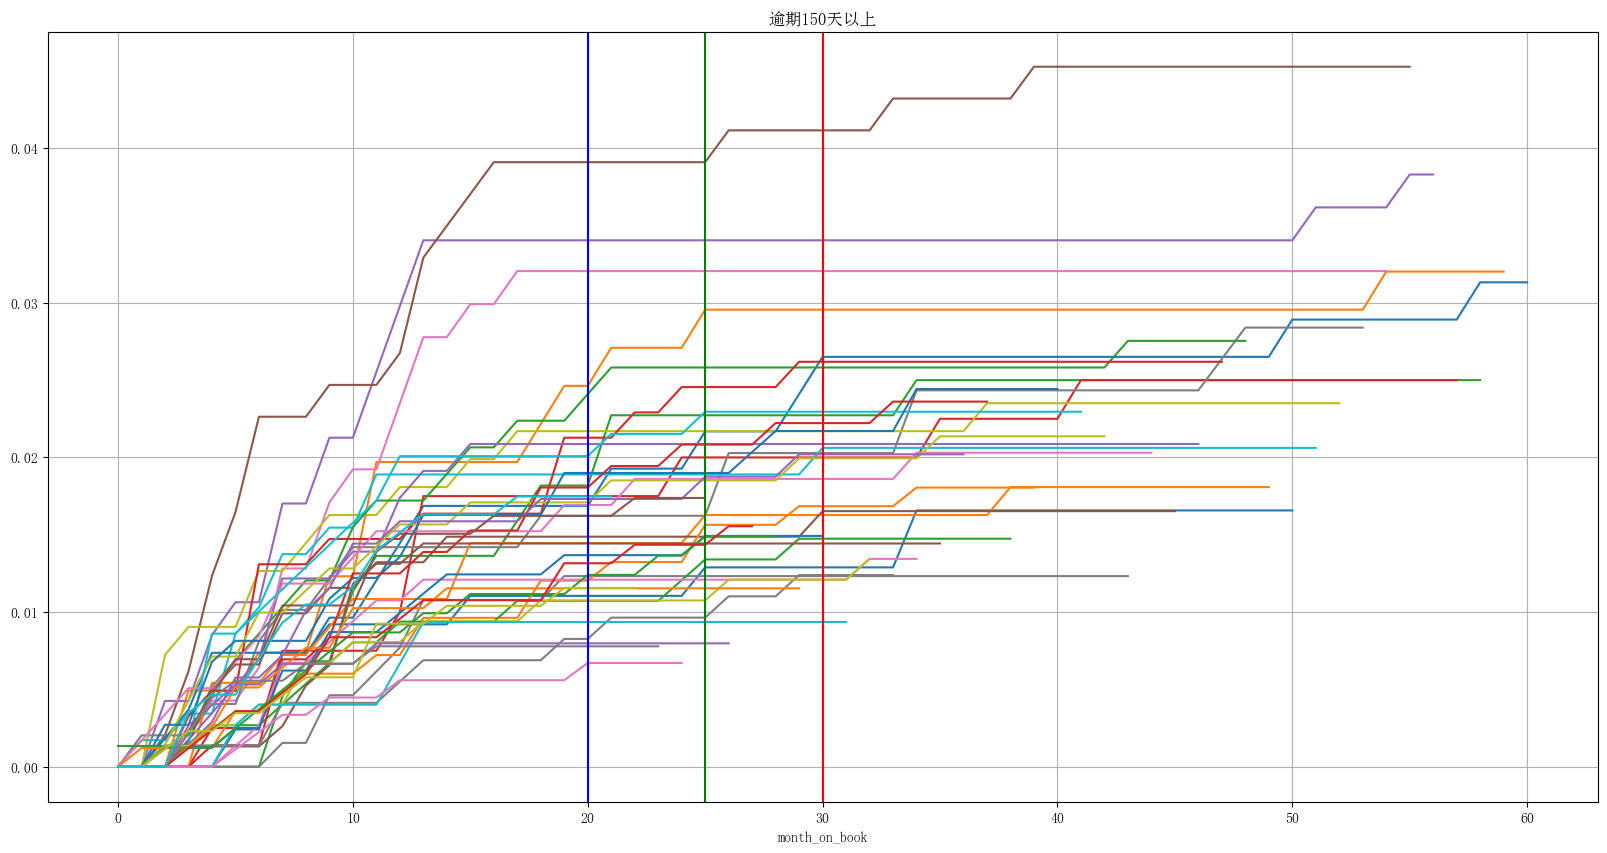

In [11]:
lst = [i for i in range(0, 61)]
vintage_wide[lst].T.plot(figsize=(20, 10),legend=False,grid=True,title='逾期150天以上')
plt.axvline(30,color='r')
plt.axvline(25,color='g')
plt.axvline(20,color='b')
plt.show()

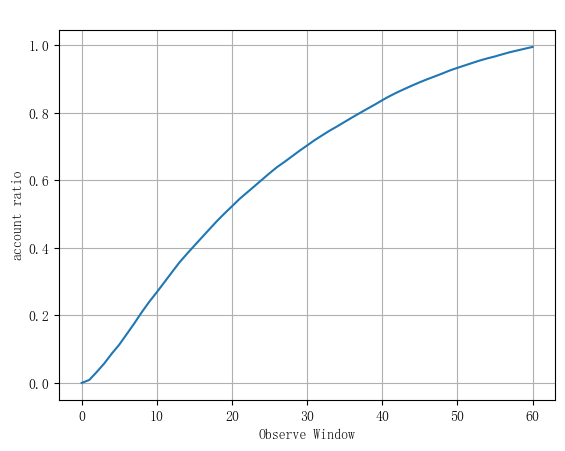

In [12]:
lst = []
for i in range(0,61):
    ratio = len(pivot_table[pivot_table['window'] < i]) / len(set(pivot_table['ID']))
    lst.append(ratio)
    
pd.Series(lst).plot(legend = False, grid = True, title = ' ')
plt.xlabel('Observe Window')
plt.ylabel('account ratio')
plt.show()

In [13]:
def calculate_observe(credit, command):
    '''calculate observe window
    '''
    id_sum = len(set(pivot_table['ID']))
    credit['status'] = 0
    exec(command)
    #credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1
    credit['month_on_book'] = credit['MONTHS_BALANCE'] - credit['open']
    minagg = credit[credit['status'] == 1].groupby('ID')['month_on_book'].min()
    minagg = pd.DataFrame(minagg)
    minagg['ID'] = minagg.index
    obslst = pd.DataFrame({'month_on_book':range(0,61), 'rate': None})
    lst = []
    for i in range(0,61):
        due = list(minagg[minagg['month_on_book']  == i]['ID'])
        lst.extend(due)
        obslst.loc[obslst['month_on_book'] == i, 'rate'] = len(set(lst)) / id_sum 
    return obslst['rate']

command = "credit.loc[(credit['STATUS'] == '0') | (credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"   
morethan1 = calculate_observe(credit_data, command)
command = "credit.loc[(credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"   
morethan30 = calculate_observe(credit_data, command)
command = "credit.loc[(credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan60 = calculate_observe(credit_data, command)
command = "credit.loc[(credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan90 = calculate_observe(credit_data, command)
command = "credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan120 = calculate_observe(credit_data, command)
command = "credit.loc[(credit['STATUS'] == '5'), 'status'] = 1"
morethan150 = calculate_observe(credit_data, command)

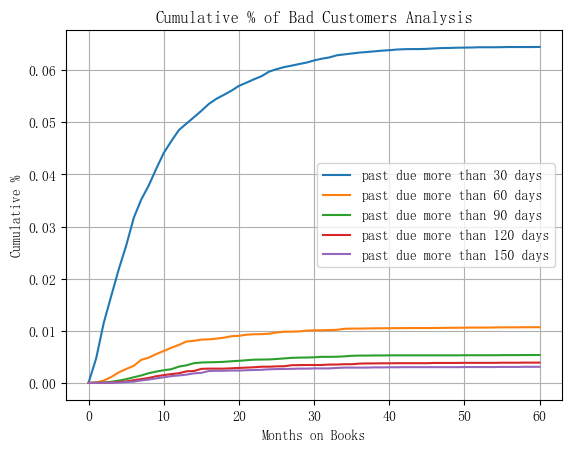

In [14]:
obslst = pd.DataFrame({'past due more than 30 days': morethan30,
                       'past due more than 60 days': morethan60,
                       'past due more than 90 days': morethan90,
                       'past due more than 120 days': morethan120,
                       'past due more than 150 days': morethan150
                        })

obslst.plot(grid = True, title = 'Cumulative % of Bad Customers Analysis')
plt.xlabel('Months on Books')
plt.ylabel('Cumulative %')
plt.show()

In [15]:
def calculate_rate(pivot_tb, command): 
    '''calculate bad customer rate
    '''
    credit_copy['status'] = None
    exec(command) # excuate input code
    sumagg = credit_copy.groupby('ID')['status'].agg(sum)
    pivot_tb = pd.merge(pivot_tb, sumagg, on = 'ID', how = 'left')
    pivot_tb.loc[pivot_tb['status'] > 1, 'status'] = 1
    rate = pivot_tb['status'].sum() / len(pivot_tb)
    return round(rate, 5)

command = "credit_copy.loc[(credit_copy['STATUS'] == '0') | (credit_copy['STATUS'] == '1') | (credit_copy['STATUS'] == '2') | (credit_copy['STATUS'] == '3' )| (credit_copy['STATUS'] == '4' )| (credit_copy['STATUS'] == '5'), 'status'] = 1"   
morethan1 = calculate_rate(pivot_table, command)
command = "credit_copy.loc[(credit_copy['STATUS'] == '1') | (credit_copy['STATUS'] == '2') | (credit_copy['STATUS'] == '3' )| (credit_copy['STATUS'] == '4' )| (credit_copy['STATUS'] == '5'), 'status'] = 1"   
morethan30 = calculate_rate(pivot_table, command)
command = "credit_copy.loc[(credit_copy['STATUS'] == '2') | (credit_copy['STATUS'] == '3' )| (credit_copy['STATUS'] == '4' )| (credit_copy['STATUS'] == '5'), 'status'] = 1"
morethan60 = calculate_rate(pivot_table, command)
command = "credit_copy.loc[(credit_copy['STATUS'] == '3' )| (credit_copy['STATUS'] == '4' )| (credit_copy['STATUS'] == '5'), 'status'] = 1"
morethan90 = calculate_rate(pivot_table, command)
command = "credit_copy.loc[(credit_copy['STATUS'] == '4' )| (credit_copy['STATUS'] == '5'), 'status'] = 1"
morethan120 = calculate_rate(pivot_table, command)
command = "credit_copy.loc[(credit_copy['STATUS'] == '5'), 'status'] = 1"
morethan150 = calculate_rate(pivot_table, command)

summary_dt = pd.DataFrame({'situation':['past due more than 1 day',
                               'past due more than 30 days',
                               'past due more than 60 days',
                               'past due more than 90 days',
                               'past due more than 120 days',
                               'past due more than 150 days'],
                      'bad customer ratio':[morethan1,
                               morethan30,
                               morethan60,
                               morethan90, 
                               morethan120,
                               morethan150, 
                      ]})
summary_dt

,situation,bad customer ratio
0,past due more than 1 day,0.87054
1,past due more than 30 days,0.11634
2,past due more than 60 days,0.01450
3,past due more than 90 days,0.00720
4,past due more than 120 days,0.00528
5,past due more than 150 days,0.00424


        ID  month_on_book  truncate
0  5001713             21         0
1  5001715             59         0
2  5001717             21         0
3  5001718             38         0
4  5001719             42         0


<Axes: xlabel='timeline'>

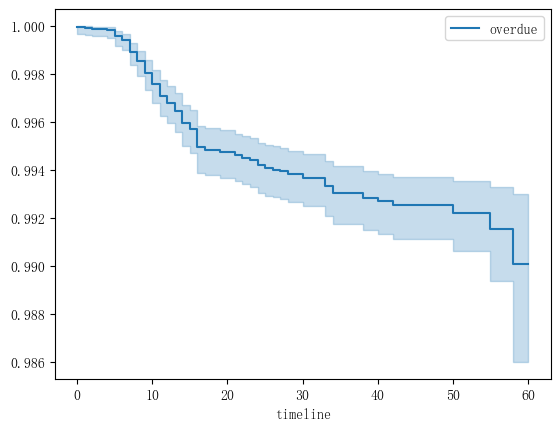

In [16]:
credit_data['truncate'] = credit_data.groupby('ID')['status'].transform('max')
truncate = credit_data.loc[credit_data['truncate']==1,]
not_trunc = credit_data.loc[credit_data['truncate']==0,]

dt1 = not_trunc.groupby('ID').agg({'month_on_book': ['max'],
                            'truncate':['max']
                           })
dt1.reset_index(inplace = True)
dt1.columns = ['ID','month_on_book','truncate']
dt2 = truncate.loc[truncate['status']==1,].groupby('ID').agg({'month_on_book': ['min'],
                            'truncate':['max']
                           })
dt2.reset_index(inplace = True)
dt2.columns = ['ID','month_on_book','truncate'] 
dt = dt1.append(dt2)

print(dt.head())

kmf = KaplanMeierFitter()
kmf.fit(dt['month_on_book'], event_observed=dt['truncate'], label='overdue')
kmf.plot()

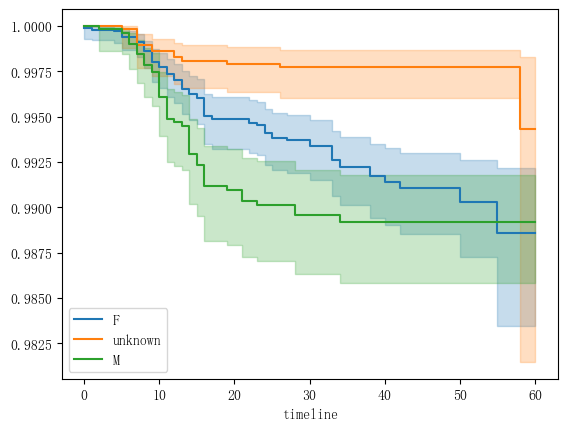

In [17]:
application = application[['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']]
dt = pd.merge(dt, application, on = 'ID', how = 'left')
dt.fillna('unknown',inplace=True)

def plot_km(dt, timevar, truncate, groupby):
    '''plot km by subgroup
    '''
    plt.rcParams['figure.facecolor'] = 'white'
    kmf = KaplanMeierFitter()
    t = np.linspace(0, 60, 61)
    for i in dt[groupby].value_counts().index:
        kmf.fit(dt[dt[groupby] == i][timevar], event_observed=dt[dt[groupby] == i][truncate], timeline=t, label=i)
        ax = kmf.plot()

plot_km(dt, 'month_on_book', 'truncate', 'CODE_GENDER')

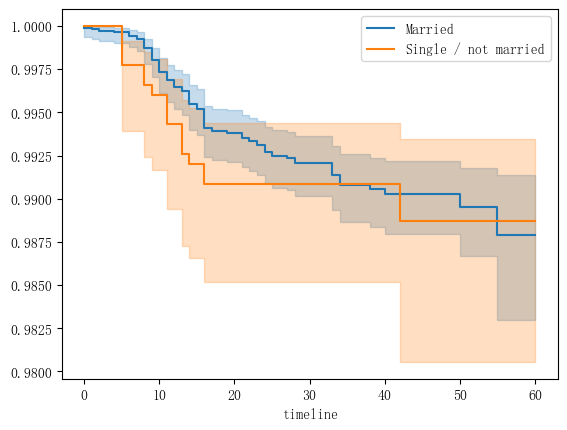

In [18]:
kmf = KaplanMeierFitter()
t = np.linspace(0, 60, 61)
kmf.fit(dt[dt['NAME_FAMILY_STATUS'] == 'Married']['month_on_book'], event_observed=dt[dt['NAME_FAMILY_STATUS'] == 'Married']['truncate'], timeline=t, label="Married")
ax = kmf.plot()

kmf.fit(dt[dt['NAME_FAMILY_STATUS'] == 'Single / not married']['month_on_book'], event_observed=dt[dt['NAME_FAMILY_STATUS'] == 'Single / not married']['truncate'], timeline=t, label="Single / not married")
ax = kmf.plot()